In [232]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy
from control import lqr, dare
from single_photons.estimators.kalman import KalmanFilter
import single_photons.utils.constants as ct
from single_photons.utils.parameters import *
from single_photons.environment import Cavity_Particle

In [323]:
T = 293
rho = 2200
index_refraction = 1.4440
p = 1e-6
radius = 75e-9
wavelength = 1.064e-6
power = 300e-3
tweezer_waist = 0.6e-6
eta_detection = 0.178
delta_t = 3e-10
control_step = int(30*1e-9/delta_t) # defined as int, number of time steps of simulation necessary to compute the control policy
fs = 1/(control_step*delta_t)

cavity_waist = 100e-6
cavity_length = 50e-3
coupling = 6.68e-42

detuning_ratio = 0.25 #defined with respect to the particle's frequency
cavity_linewidth_ratio = 0.5
optomechanical_coupling_ratio = 3

gamma, omega, ba_force, std_detection, std_z, g_cs, detuning, cavity_linewidth =\
compute_parameters_simulation_cavity(power, wavelength, tweezer_waist, radius, p, fs, eta_detection,\
                                     cavity_length, cavity_waist, detuning_ratio, cavity_linewidth_ratio,\
                                     T = T, rho = rho, index_refraction = index_refraction)

In [324]:
period = 2 * np.pi / omega
t = np.arange(0, 20 * period, delta_t)
N = t.shape[0]

coupling = (1/(4*np.pi))*(ba_force**2)
coupling

4.1682488674527876e-42

In [325]:
env = Cavity_Particle(
    omega,
    gamma,
    detuning,
    cavity_linewidth,
    optomechanical_coupling_ratio*omega,
    coupling,
    radius=radius,
    rho=rho,
    eta_detection=eta_detection,
    T=T
)
std_detection

1.4099653681937528e-10

In [326]:
pulse_amplitude = 10
pulse_center = 5000+int(3*t.shape[0]/4)
round_trip_time = 2*cavity_length/ct.c
#https://www.rp-photonics.com/q_factor.html inverse of loss gives the average amount of round trips
trips = 1/(2*np.pi*round_trip_time*cavity_linewidth_ratio*omega)
pulse_width = trips*round_trip_time/delta_t
alpha_in = []
for i in range(t.shape[0]):
    alpha = pulse_amplitude/(np.sqrt(delta_t) * np.power(np.pi*pulse_width**2,1/4)) * (
        np.exp(-((i - pulse_center) ** 2) / (2 * pulse_width**2))
    )
    alpha_in.append(alpha)

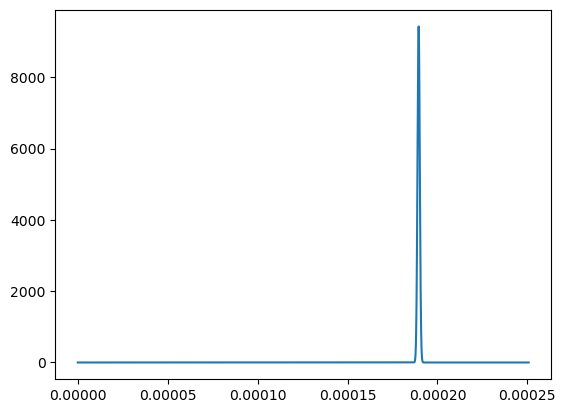

2116.7046933085485
99.99999999999895


In [327]:
plt.plot(t, alpha_in)
plt.show()
pulse_width
s=0
for el in alpha_in:
    s = s+el**2*delta_t
print(pulse_width)
print(s)

In [328]:
variance_process = env.thermal_force_std**2 + env.backaction_std**2
print(std_detection, variance_process,trips)

1.4099653681937528e-10 537605.4136351169 1903.7163086013177


In [329]:
Q = np.array(
    [
        [(env.__optical_noise__**2)*cavity_linewidth, 0, 0, 0],
        [0, (env.__optical_noise__**2)*cavity_linewidth, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, variance_process],
    ]
)*control_step*delta_t/2
R = np.array([[np.power(std_detection, 2)]])

In [330]:
g_fb = 5*omega
Ad = scipy.linalg.expm(env.A *control_step*delta_t)
Bd = env.B * delta_t * control_step
cost_states = np.array([[1e-15, 0, 0, 0],
                        [0, 1e-15, 0, 0],
                        [0, 0, omega/2, 0],
                        [0, 0, 0, omega/2]
                       ])
(G_lqr, S, E) = lqr(env.A, env.B, cost_states, omega/(g_fb**2))
X, L, G = dare(Ad, Bd, cost_states, omega/(g_fb**2))
G_lqr, G

(array([[-4709076.40506051,  -844998.54747148,  4575028.44963053,
          2779832.05540536]]),
 array([[-4739401.04704838,  -827401.11993914,  4432458.48583421,
          2735133.81311748]]))

In [331]:
if std_detection < 1:
    std_detection = std_detection/env.zp_x
x0 = 0
P0 = np.matrix([[0,0,0,0],
               [0,0,0,0],
               [0,0,3e8,0],
               [0,0,0,3e8]])
estimation = np.matrix([[0], [0], [x0], [0]])
states = np.array([[0], [0], [x0], [0.0]])
G, omega, Ad, env.B*delta_t*control_step
new_states = np.zeros((N, 4))
measured_states = np.zeros((N))
estimated_states = np.zeros((N, 4))
estimated_states[0, :] = estimation.reshape((4))
estimation = estimation.reshape((4, 1))
control = np.array([[0]])
estimate_Vx = []
estimate_Vp = []
controls = []
kalman = KalmanFilter(estimation, P0, Ad, env.B * delta_t * control_step, env.C, Q * delta_t * control_step, R)
for i in tqdm(range(t.shape[0])):
    new_states[i, :] = states[:, 0]
    if not i % control_step:
        measured_states[i] = states[2, 0] + std_detection * np.random.normal()
        kalman.propagate_dynamics(control)
        kalman.compute_aposteriori(measured_states[i])
        estimated_states[i, :] = kalman.estimates_aposteriori[int(i/control_step)][:, 0].reshape((4))
        estimation = estimated_states[i, :].reshape((4, 1))
        estimate_Vx.append(np.array(kalman.error_covariance_aposteriori[-1][2, 2]))
        estimate_Vp.append(np.array(kalman.error_covariance_aposteriori[-1][3, 3]))
        control = -np.matmul(G, estimation)
    else:
        measured_states[i] = measured_states[i-1]
        estimated_states[i, :] = estimated_states[i-1,:]
        estimate_Vx.append(estimate_Vx[-1])
        estimate_Vp.append(estimate_Vp[-1])

    controls.append(float(control))
    states = env.step(states, alpha_in=alpha_in[i], control=control, delta_t=delta_t)

  0%|                                                                                       | 0/835642 [00:00<?, ?it/s]C:\Users\jorge\AppData\Local\Temp\ipykernel_12492\1781500217.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  new_states[i, :] = states[:, 0]
C:\Users\jorge\AppData\Local\Temp\ipykernel_12492\1781500217.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  measured_states[i] = states[2, 0] + std_detection * np.random.normal()
100%|███████████████████████████████████████████████████████████████████████| 835642/835642 [01:12<00:00, 11509.70it/s]


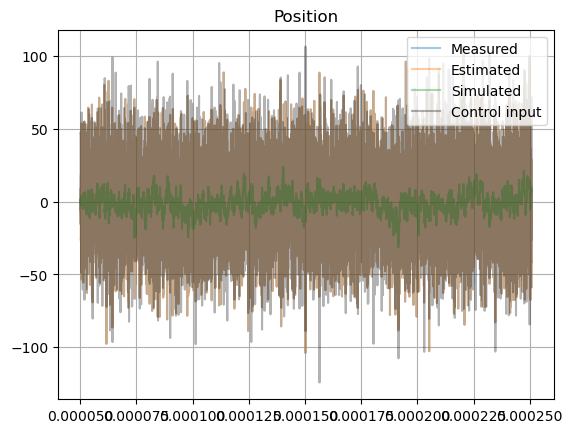

In [332]:
plt.close("all")
fig1 = plt.Figure()
plt.title("Position")
plt.plot(t[int(1/5*t.shape[0]):], measured_states[int(1/5*t.shape[0]):], alpha = 0.4)
plt.plot(t[int(1/5*t.shape[0]):], estimated_states[int(1/5*t.shape[0]):, 2], alpha = 0.4)
plt.plot(t[int(1/5*t.shape[0]):], new_states[int(1/5*t.shape[0]):, 2],alpha = 0.4)
C = max(controls[int(1/5*t.shape[0]):])/max(measured_states[int(1/5*t.shape[0]):])
controls = [x/C for x in controls]
plt.plot(t[int(1/5*t.shape[0]):], controls[int(1/5*t.shape[0]):], alpha = 0.3,color = 'black')
plt.grid()
plt.legend(["Measured", "Estimated", "Simulated", "Control input"],loc = 'upper right')
plt.show()

In [333]:
#plt.close("all")
#fig1 = plt.Figure()
#plt.title("Velocity")
#plt.plot(t[1:], estimated_states[1:, 3], alpha = 0.95)
#plt.plot(t[1:], new_states[1:, 3],alpha = 0.95)
#plt.grid()
#plt.legend(["Estimated", "Simulated"])
#plt.show()

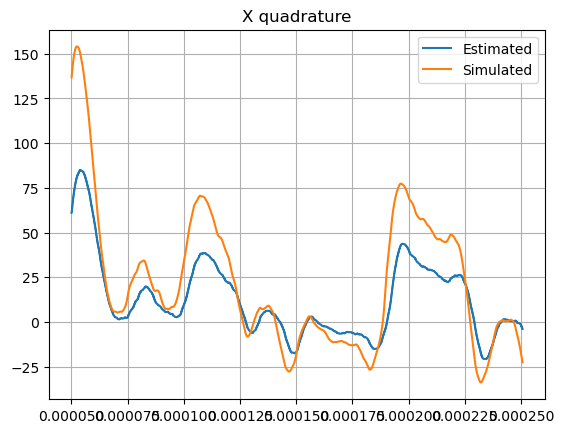

In [335]:
plt.figure()
fig2 = plt.Figure()
plt.title('X quadrature')
plt.plot(t[int(1/5*t.shape[0]):], estimated_states[int(1/5*t.shape[0]):,0])
plt.plot(t[int(1/5*t.shape[0]):], new_states[int(1/5*t.shape[0]):,0])
plt.grid()
plt.legend(['Estimated','Simulated'])
plt.show()

In [261]:

# In[63]:
#fig2 = plt.Figure()
#plt.figure()
#plt.title("Photon number")
#plt.plot(
#    t[1:], np.power(estimated_states[1:, 0], 2) + np.power(estimated_states[1:, 1], 2)
#)
#plt.plot(t[1:], np.power(new_states[1:, 0], 2) + np.power(new_states[1:, 1], 2))
#plt.grid()
#plt.legend(["Estimated", "Simulated"])
#plt.show()


In [292]:
print(kalman.error_covariance_apriori[-1], g_cs, std_detection)

[[   8.56839822   57.97589984  -16.701986    -24.07694471]
 [  57.97589984  392.27926575 -113.00976479 -162.91055793]
 [ -16.701986   -113.00976479   32.55641594   46.93208498]
 [ -24.07694471 -162.91055793   46.93208498   67.65550009]] 96952.75519415858 27.10612091496197
